In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
pip install pydicom

In [5]:
import warnings; warnings.filterwarnings('ignore')
import pandas as pd, numpy as np
import matplotlib.pyplot as plt

import os, zipfile, random, csv
import seaborn as sns
import pydicom as dcm
from glob import glob
import cv2

In [6]:
import os; 
os.chdir('/content/drive/My Drive/Capstone Project Data')

In [ ]:
# # Install packages
#!pip install -q pydicom

In [7]:

print(f'Current working directory: {os.getcwd()}')
print('Folder and Files in current directory: {}'.format(os.listdir()))
PATH = '/content/drive/My Drive/'
DATA_FOLDER = os.path.join(PATH, '/content/drive/My Drive/Capstone Project Data')
Folder_DCM_IMAGES = os.path.join(DATA_FOLDER,'stage_2_train_images/')

WORKING_FOLDER = os.path.join(PATH,'working/')
SAVE_PATH = os.path.join(WORKING_FOLDER,'Saved_Data/')

if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)
    

print("DATA_FOLDER: ", DATA_FOLDER)  
print("Folder_DCM_IMAGES: ", Folder_DCM_IMAGES) 
print("SAVE_PATH: ", SAVE_PATH) 
print("WORKING_FOLDER: ", WORKING_FOLDER) 

os.chdir(WORKING_FOLDER)
print(f'Current working directory: {os.getcwd()}')

Current working directory: /content/drive/.shortcut-targets-by-id/1FgWGUwp3BmaP7584YA7xDcHq4yyvR901/Capstone Project Data
Folder and Files in current directory: ['GCP Credits Request Link - RSNA.txt', 'stage_2_detailed_class_info.csv', 'stage_2_sample_submission.csv', 'stage_2_train_labels.csv', 'stage_2_test_images', 'stage_2_train_images', '.ipynb_checkpoints', 'data', 'working']
DATA_FOLDER:  /content/drive/My Drive/Capstone Project Data
Folder_DCM_IMAGES:  /content/drive/My Drive/Capstone Project Data/stage_2_train_images/
SAVE_PATH:  /content/drive/My Drive/working/Saved_Data/
WORKING_FOLDER:  /content/drive/My Drive/working/
Current working directory: /content/drive/My Drive/working


In [8]:
os.chdir('/content/drive/My Drive/Capstone Project Data')

In [9]:
train_labels = pd.read_csv(os.path.join(DATA_FOLDER,'/content/drive/My Drive/Capstone Project Data/stage_2_train_labels.csv'))
class_info = pd.read_csv(os.path.join(DATA_FOLDER,'/content/drive/My Drive/Capstone Project Data/stage_2_detailed_class_info.csv'))

In [10]:
train_labels.fillna(0, inplace=True)

In [11]:
train_labels

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0.0,0.0,0.0,0.0,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,0.0,0.0,0.0,0.0,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,0.0,0.0,0.0,0.0,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0.0,0.0,0.0,0.0,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
...,...,...,...,...,...,...
30222,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,185.0,298.0,228.0,379.0,1
30223,c1edf42b-5958-47ff-a1e7-4f23d99583ba,0.0,0.0,0.0,0.0,0
30224,c1f6b555-2eb1-4231-98f6-50a963976431,0.0,0.0,0.0,0.0,0
30225,c1f7889a-9ea9-4acb-b64c-b737c929599a,570.0,393.0,261.0,345.0,1


In [12]:
print(f'Train Labels dataframe has {train_labels.shape[0]} rows and {train_labels.shape[1]} columns')
print(f'Class info dataframe has {class_info.shape[0]} rows and {class_info.shape[1]} columns')
print('Number of duplicates in patientID in train labels dataframe: {}'.format(len(train_labels) - (train_labels['patientId'].nunique())))
print('Number of duplicates in patientID in class info dataframe: {}'.format(len(class_info) - (class_info['patientId'].nunique())))

Train Labels dataframe has 30227 rows and 6 columns
Class info dataframe has 30227 rows and 2 columns
Number of duplicates in patientID in train labels dataframe: 3543
Number of duplicates in patientID in class info dataframe: 3543


In [13]:
import os
import csv
import random
!pip install pydicom
import pydicom
import numpy as np
import pandas as pd
from skimage import io
from skimage import measure
from skimage.transform import resize

import tensorflow as tf
from tensorflow import keras

from matplotlib import pyplot as plt
import matplotlib.patches as patches

In [14]:
TRAIN_PATH = os.path.join(DATA_FOLDER +'/stage_2_train_images/')

print(TRAIN_PATH)
filenames = {}

read_directory = True # False
if(read_directory):
  filenames = os.listdir(TRAIN_PATH)
  pd.DataFrame(filenames).to_csv(SAVE_PATH+'train_path_listdir.csv')
else:
  filenames=pd.read_csv(SAVE_PATH+'train_path_listdir.csv', usecols=[1],header=0).values.tolist()
  filenames = [val for sublist in filenames for val in sublist]


/content/drive/My Drive/Capstone Project Data/stage_2_train_images/


In [15]:

# Use part of the data for training earlier and then run for 100% of the data
percentage_data_used = 100
file_count = int(len(filenames)*percentage_data_used/100)
print("Total files available:",file_count)

random.shuffle(filenames)

# split into train and validation filenames
n_valid_samples = int(file_count * 0.3)

train_filenames = filenames[n_valid_samples:file_count]
valid_filenames = filenames[:n_valid_samples]
print('n train samples', len(train_filenames))
print('n valid samples', len(valid_filenames))
n_train_samples = len(filenames) - n_valid_samples

image_dimension = 224
print('Image Dimension to use:',image_dimension)
print('sample file:',filenames[0])

Total files available: 26684
n train samples 18679
n valid samples 8005
Image Dimension to use: 224
sample file: 71665ab7-b4e9-4734-af2c-216a66706d5e.dcm


In [16]:
# Check dist of selected files based on the csv that was provided. 
# Did not try stratified sampling since the distribution is not impacted much.
def check_distribution(dataframe_to_check):
  filename_check = pd.DataFrame(columns=['patientId','class'])
  #get filename 
  for filename in dataframe_to_check:
    filename_check = filename_check.append(class_info[class_info['patientId'] == filename.split('.')[0]])
    
  print('Rows',len(filename_check))
  print('unique',len(filename_check['patientId'].unique()))
  print(filename_check['class'].value_counts(normalize = True))

check_distribution(train_filenames)
check_distribution(valid_filenames)

Rows 21214
unique 18679
No Lung Opacity / Not Normal    0.388470
Lung Opacity                    0.321439
Normal                          0.290091
Name: class, dtype: float64
Rows 9013
unique 8005
No Lung Opacity / Not Normal    0.397204
Lung Opacity                    0.303562
Normal                          0.299234
Name: class, dtype: float64


In [17]:
# empty dictionary
pneumonia_locations = {}
# load table
with open(os.path.join(DATA_FOLDER,'stage_2_train_labels.csv'), mode='r') as infile:
    # open reader
    reader = csv.reader(infile)
    # skip header
    next(reader, None)
    # loop through rows
    for rows in reader:
        # retrieve information
        filename = rows[0]
        location = rows[1:5]
        pneumonia = rows[5]
        # if row contains pneumonia add label to dictionary
        # which contains a list of pneumonia locations per filename
        if pneumonia == '1':
            # convert string to float to int
            location = [int(float(i)) for i in location]
            # save pneumonia location in dictionary
            if filename in pneumonia_locations:
                pneumonia_locations[filename].append(location)
            else:
                pneumonia_locations[filename] = [location]

In [19]:
import keras

# The dataset is too large to fit into memory, so we need to create a generator that loads data on the fly.
# Generator class to handle:
# Image load from folder during train and predict modes, shuffle on epoc end, 
# resize loaded images, augment if needed, add trailing channel dimension
class generator(keras.utils.Sequence):
    
    def __init__(self, folder, filenames, pneumonia_locations=None, batch_size=128, image_size=image_dimension, shuffle=True, augment=False, predict=False):
        self.folder = folder
        self.filenames = filenames
        self.pneumonia_locations = pneumonia_locations
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.augment = augment
        self.predict = predict
        self.on_epoch_end()
        
    # Loads the file from folder, resizes and augments the data with horizontal flip    
    def __load__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename), force=True).pixel_array
        
        
        # create empty mask
        msk = np.zeros(img.shape)
        img = np.stack((img,)*3, axis=-1)#binu code
        # get filename without extension
        filename = filename.split('.')[0]
        # if image contains pneumonia
        if filename in self.pneumonia_locations:
            # loop through pneumonia
            for location in self.pneumonia_locations[filename]:
                # add 1's at the location of the pneumonia
                x, y, w, h = location
                msk[y:y+h, x:x+w] = 1
        # resize both image and mask
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        msk = resize(msk, (self.image_size, self.image_size), mode='reflect') > 0.5
        # if augment then horizontal flip half the time
        if self.augment and random.random() > 0.5:
            img = np.fliplr(img)
            msk = np.fliplr(msk)
        # add trailing channel dimension
        return img, msk
    
    # Loads images during prediction cycles
    def __loadpredict__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename), force=True).pixel_array
        img = np.stack((img,)*3, axis=-1)#binu code
        
        # resize image
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        # add trailing channel dimension
        return img
        
    # Generator must implement this getter function    
    def __getitem__(self, index):
        # select batch
        filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]
        # predict mode: return images and filenames
        if self.predict:
            # load files
            imgs = [self.__loadpredict__(filename) for filename in filenames]
            # create numpy batch
            imgs = np.array(imgs)
            return imgs, filenames
        # train mode: return images and masks
        else:
            # load files
            items = [self.__load__(filename) for filename in filenames]
            # unzip images and masks
            imgs, msks = zip(*items)
            # create numpy batch
            imgs = np.array(imgs)
            msks = np.array(msks)
            return imgs, msks

    # Shuffle data before start of next epoc    
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.filenames)
        
    def __len__(self):
        if self.predict:
            # return everything
            return int(np.ceil(len(self.filenames) / self.batch_size))
        else:
            # return full batches only
            return int(len(self.filenames) / self.batch_size)

## Layers and Model Architecture

In [20]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape, BatchNormalization
from tensorflow.keras.models import Model


# Model creator
def create_model(input_size, trainable=False, channels, n_blocks=2, depth=5):
    model = MobileNet(input_shape=(input_size, input_size, 3), include_top=False, alpha=1.0, weights = "imagenet", dropout=0.4)

    block1 = model.get_layer("conv_pw_1_relu").output
    block2 = model.get_layer("conv_pw_3_relu").output
    block3 = model.get_layer("conv_pw_5_relu").output
    block6 = model.get_layer("conv_pw_11_relu").output
    block7 = model.get_layer("conv_pw_13_relu").output

    x = Concatenate()([UpSampling2D()(block7), block6])
    x = BatchNormalization()(x)
    x = Concatenate()([UpSampling2D()(x), block3])
    x = BatchNormalization()(x)
    x = Concatenate()([UpSampling2D()(x), block2])
    x = BatchNormalization()(x)
    x = Concatenate()([UpSampling2D()(x), block1])
    x = BatchNormalization()(x)
    x =  UpSampling2D()(x)
    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)
    x = Reshape((input_size, input_size))(x)

    return Model(inputs=model.input, outputs=x)

## Learning Functions

In [21]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
# model = create_model(False)


optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

# model.summary()
PATIENCE = 3

checkpoint = ModelCheckpoint(SAVE_PATH + "model-{val_loss:.2f}.h5", monitor="val_loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="auto", period=1)
stop = EarlyStopping(monitor="val_loss", patience=PATIENCE, mode="auto")
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=2, min_lr=1e-12, verbose=1, mode="auto")

In [22]:
# define iou or jaccard loss function
def iou_loss(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(float(y_true) * float(y_pred))
    score = (intersection + 1.) / (tf.reduce_sum(float(y_true)) + tf.reduce_sum(float(y_pred)) - intersection + 1.)
    return 1 - score

# combine bce loss and iou loss
def iou_bce_loss(y_true, y_pred):
    return 0.5 * keras.losses.binary_crossentropy(y_true, y_pred) + 0.5 * iou_loss(y_true, y_pred)

# mean iou as a metric
def mean_iou(y_true, y_pred):
    y_pred = tf.round(y_pred)
    intersect = tf.reduce_sum(float(y_true) * float(y_pred), axis=[1])
    union = tf.reduce_sum(float(y_true),axis=[1]) + tf.reduce_sum(float(y_pred),axis=[1])
    smooth = tf.ones(tf.shape(intersect))
    return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))


# create network and compiler
model = create_model(input_size=image_dimension)

model.compile(loss= iou_loss, optimizer=optimizer, metrics=['accuracy', mean_iou]) 

model.summary()

# cosine learning rate annealing
# changes learning rate based on the number of epocs passed
def cosine_annealing(x):
    lr = 1e-4
    epochs = 5
    return lr* (np.cos(np.pi*x/epochs)+1.) /2
learning_rate = tf.keras.callbacks.LearningRateScheduler(cosine_annealing)

# keeps logging the epoc output simultaneously while training
csv_logger = tf.keras.callbacks.CSVLogger(SAVE_PATH + 'logs_cnn_segment.csv', append = True)

# Creating checkpoint of the best model to avoid save errors later on.
# Saves training time once the best model is achieved.
cp = tf.keras.callbacks.ModelCheckpoint(filepath = SAVE_PATH + 'model_checkpoint.h5', verbose = 1, save_best_only = True)

# Keep monitoring val_loss to see if there is any improvement. 
# Mostly the model kept loss in a range so keeping patience as 4 to avoid bloating training time. 
# Any improvement of 0.5% in val_loss would get captured
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.005, patience=2, restore_best_weights=True, verbose=1, mode='auto')

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
_______________________________________________________________________________________

In [23]:
# create train and validation generators
TRAIN_PATH = os.path.join(DATA_FOLDER +'/stage_2_train_images/')

train_gen = generator(TRAIN_PATH, train_filenames, pneumonia_locations, batch_size=8, image_size=image_dimension, shuffle=True, augment=True, predict=False)
valid_gen = generator(TRAIN_PATH, valid_filenames, pneumonia_locations, batch_size=8, image_size=image_dimension, shuffle=False, predict=False)

history = model.fit_generator(generator=train_gen,
                    epochs=5,
                    validation_data=valid_gen,
                    callbacks=[checkpoint, reduce_lr, stop],
                    workers=4,
                    #use_multiprocessing=True,
                    shuffle=True)

# Save Model and history
training_mode = True
if(training_mode):
  export_file_path = SAVE_PATH+'pneumonia_model.h5'

  # Save the model
  model.save(export_file_path)
  print('model saved')

  # Save history file
  print(history.history.keys())
  # convert the history.history dict to a pandas DataFrame:     
  hist_df = pd.DataFrame(history.history) 

  # or save to csv: 
  hist_csv_file = SAVE_PATH+'pneumonia_model_history.csv'
  with open(hist_csv_file, mode='w') as f:
      hist_df.to_csv(f)
  print('history saved')

  
else:
  model.load_weights(SAVE_PATH+'pneumonia_model.h5')
  history = pd.read_csv(SAVE_PATH+'pneumonia_model_history.csv')
  history

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/5
2334/2334 [==============================] - ETA: 0s - loss: 0.7895 - accuracy: 0.0035 - mean_iou: 0.8222
Epoch 00001: val_loss improved from inf to 0.75282, saving model to /content/drive/My Drive/working/Saved_Data/model-0.75.h5
2334/2334 [==============================] - 5866s 3s/step - loss: 0.7895 - accuracy: 0.0035 - mean_iou: 0.8222 - val_loss: 0.7528 - val_accuracy: 0.0020 - val_mean_iou: 0.8825
Epoch 2/5
2334/2334 [==============================] - ETA: 0s - loss: 0.7241 - accuracy: 0.0020 - mean_iou: 0.8892
Epoch 00002: val_loss improved from 0.75282 to 0.74582, saving model to /content/drive/My Drive/working/Saved_Data/model-0.75.h5
2334/2334 [==============================] - 3752s 2s/step - loss: 0.7241 - accuracy: 0.0020 - mean_iou: 0.8892 - val_loss: 0.7458 - val_accuracy: 0.0027 - val_mean_iou: 0.8939
Epoch 3/5
2334/2334 [==============================] - ETA: 0s - loss: 0.7130 - accu

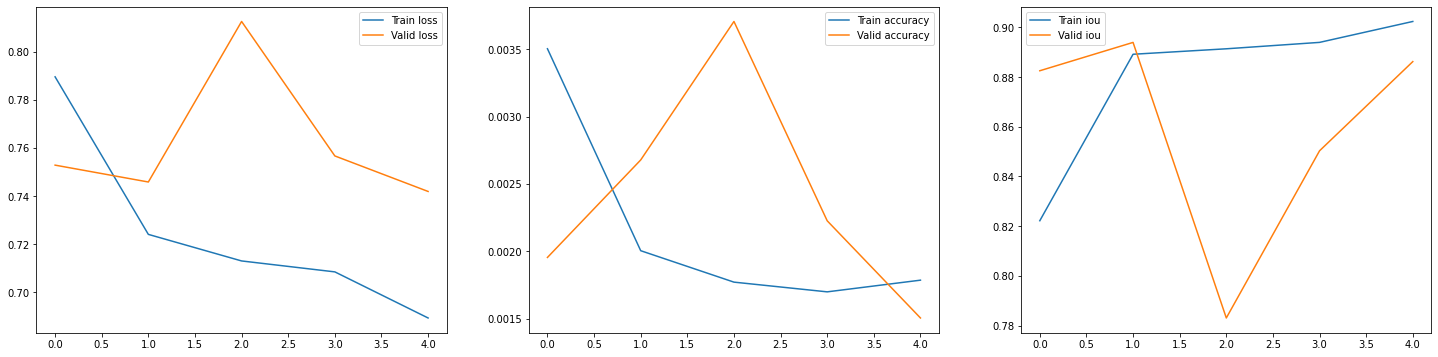

In [24]:
plt.figure(figsize=(25,6))
plt.subplot(131)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(history.epoch, history.history["accuracy"], label="Train accuracy")
plt.plot(history.epoch, history.history["val_accuracy"], label="Valid accuracy")
plt.legend()
plt.subplot(133)
plt.plot(history.epoch, history.history["mean_iou"], label="Train iou")
plt.plot(history.epoch, history.history["val_mean_iou"], label="Valid iou")
plt.legend()
plt.show()


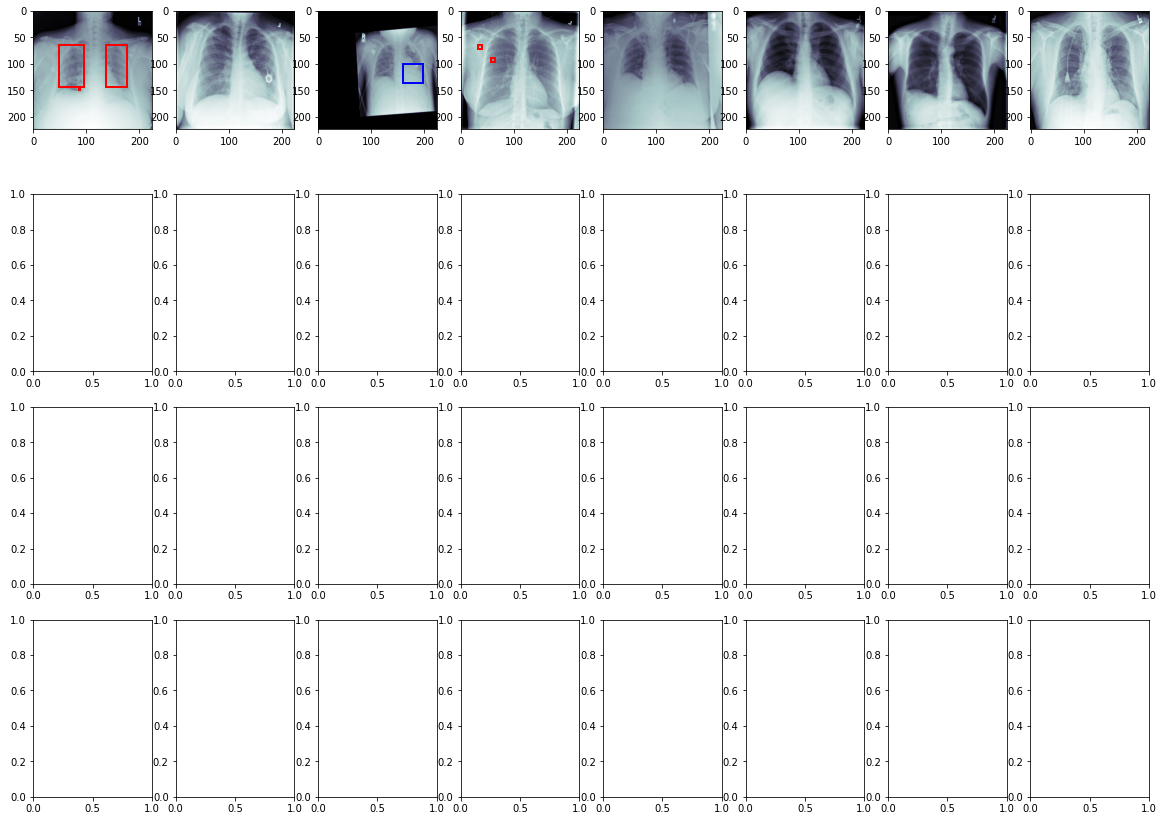

In [25]:
# Red is predicted mask, Blue is actual Mask
for imgs, msks in valid_gen:
    # predict batch of images
    preds = model.predict(imgs)
    # create figure
    f, axarr = plt.subplots(4, 8, figsize=(20,15))
    
    # Flatten the array
    axarr = axarr.ravel()
    axidx = 0
    #print(msk)
    # loop through batch
    for img, msk, pred in zip(imgs, msks, preds):
        # plot image
        axarr[axidx].imshow(img[:, :, 0],cmap='bone')
        
        # threshold true mask
        comp = msk[:, :] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            axarr[axidx].add_patch(patches.Rectangle((x,y),width,height,linewidth=2,edgecolor='b',facecolor='none'))
        
        # threshold predicted mask
        comp = pred[:, :] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            axarr[axidx].add_patch(patches.Rectangle((x,y),width,height,linewidth=2,edgecolor='r',facecolor='none'))
        axidx += 1
    plt.show()
    # only plot one batch
    break

    # There was considerable IOU for the images where prediction was correct. 